# Proyecto 1 - Etapa 1
Integrantes:
*   Jaime Torres - 202014866
*   Juan Guillermo Gutierrez - 202122659
*   Maria Luisa Rodríguez -202121549


En esta primera etapa del proyecto, se crearán tres modelos distintos con el objetivo de relacionar de forma automática nuevas
opiniones sobre los objetivos de desarrollo sostenible (ODS) 3, 4 y 5.

El documento proporcionado para el entrenamiento de dichos modelos contiene dos columnas:
- Textos_espanol (string): Contiene las opiniones de los habitantes locales que describen las problemáticas de su entorno en términos de los ODS 3,4 y 5.
- sdg (numeric): Indica el ODS del cual se habla en la opinión.

In [84]:
# Instalación de librerias
from collections import UserList

import re
import numpy as np
import pandas as pd

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE

import scipy.stats as stats

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import  SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet as wn

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
pd.reset_option('all')

url = 'https://github.com/BI-DATASCIENCE/Proyecto-1/raw/main/data/'
raw_data: pd.DataFrame = pd.read_excel(url + 'ODScat_345.xlsx')
raw_data


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marlu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marlu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marlu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marlu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\marlu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
C:\Users\marlu\AppData\Local\Temp\ipykernel_81668\1604082471.py:56: FutureWarning: data_manager option is deprecated and will be removed in a future ve

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3
...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5
4045,La participación de las mujeres en roles de li...,5
4046,"Según el WEF, según las tendencias de 2016, po...",5
4047,"Sirve como recurso y foro para las agencias, c...",5


En un primer vistazo, se puede evidenciar que hay 4049 filas y 2 columnas. Es importante recalcar que hay problemas de codificación evidentes por la forma en la que la tilde en "número" de la fila 0 se distorsionó al simbolo 'Ãº'.

## 1) Entendimiento y preparación de los datos


### 1.1) Problemas de codificación

En primer lugar, se debe verificar que los caracteres especiales de las opiniones (principalmente las tildes) se representen de manera correcta, por lo cual se cambian las instancias en las que hubo problemas al leerlas:

In [85]:
def corregir_caracteres(texto):
    if isinstance(texto, str):
        texto = texto.replace('Ã¡', 'á').replace('Ã©', 'é').replace('Ã­', 'í')
        texto = texto.replace('Ã³', 'ó').replace('Ãº', 'ú').replace('Ã±', 'ñ')
        texto = texto.replace('Ã', 'í').replace('Â', '')
        texto = texto.replace('â€œ', '').replace('â€', '').replace('â€˜', '').replace('â€™', '')
    return texto

raw_data['Textos_espanol'] = raw_data['Textos_espanol'].apply(corregir_caracteres)
raw_data

,Textos_espanol,sdg
0,"Por ejemplo, el número de consultas externas d...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3
...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5
4045,La participación de las mujeres en roles de li...,5
4046,"Según el WEF, según las tendencias de 2016, po...",5
4047,"Sirve como recurso y foro para las agencias, c...",5


A continuación, se verifica que no hayan valores faltantes dentro de las columnas del archivo. No hay ningún valor vacio en las 4049 filas

In [86]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4049 entries, 0 to 4048
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  4049 non-null   object
 1   sdg             4049 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.4+ KB


### 1.2) Limpieza de los Datos



Antes de poder 'tokenizar' las palabras para identificar las más comunes dentro del set de opiniones de un ODS específico, es necesario que los datos se encuentren libres de ciertos caracteres que no aportan valor al modelo:
- Las mayúsculas impiden una comparación correcta de una misma palabra con distinta capitalización, por lo cual se trabaja únicamente con minúsculas.
- Las 'stopwords', tambien conocidas como 'palabras vacías' se deben quitar, pues son palabras que por si solas no tienen significado, como, por ejemplo, artículos, pronombres y preposiciones. Se utiliza el set de stopwords en español de nltk para removerlas.
- La puntuación no provee detalles sobre la información que se encuentra verdaderamente en las opiniones, por lo cual deben ser removidos

In [87]:
spanish_sw = set(stopwords.words('spanish'))
print(spanish_sw)

# poner todo en minuscula
def to_lowercase(palabras):
  return [palabra.lower() for palabra in palabras]


#quitar puntuación
def remove_punctuation(palabras):
  new_words = []
  for word in palabras:
    if word is not None:
      new_word = re.sub(r'[^\w\s]', '', word)
      if new_word != '':
         new_words.append(new_word)
  return new_words

#quitar stopwords
def remove_stopwords(palabras):
  filtered_text=[]
  for palabra in palabras:
    if palabra not in spanish_sw:
        filtered_text.append(palabra)
  return filtered_text


def preprocessing(palabras):
    palabras = to_lowercase(palabras)
    palabras = remove_punctuation(palabras)
    palabras = remove_stopwords(palabras)
    return palabras

{'me', 'o', 'tuvieron', 'fueseis', 'hubieron', 'estaban', 'ha', 'han', 'habidos', 'hubisteis', 'habidas', 'tuvimos', 'somos', 'qué', 'tendrán', 'era', 'tuviese', 'ya', 'tendríais', 'siente', 'la', 'es', 'estuviese', 'estabas', 'su', 'el', 'tengan', 'le', 'tenido', 'vuestros', 'tienes', 'son', 'habréis', 'nuestra', 'estuvo', 'haya', 'habías', 'tuyos', 'tendría', 'seáis', 'hubiera', 'él', 'tanto', 'tenga', 'fue', 'estáis', 'fueses', 'tengamos', 'ante', 'os', 'estábamos', 'teniendo', 'sois', 'habríais', 'ti', 'un', 'serías', 'fui', 'estaremos', 'tenidas', 'fuéramos', 'estéis', 'por', 'fuesen', 'antes', 'fueran', 'hubiésemos', 'tendremos', 'estuvieseis', 'nosotras', 'tienen', 'tenían', 'hayáis', 'había', 'hubieses', 'unos', 'estuvierais', 'seríais', 'tuyas', 'donde', 'vuestra', 'teníais', 'estemos', 'estarán', 'ella', 'más', 'quien', 'del', 'suyas', 'habíamos', 'en', 'otro', 'tendrás', 'habéis', 'tenidos', 'míos', 'seréis', 'nos', 'para', 'tuvo', 'sentidos', 'tus', 'serán', 'esos', 'tengas

In [88]:
raw_data['palabras'] = raw_data['Textos_espanol'].apply(word_tokenize)
raw_data

,Textos_espanol,sdg,palabras
0,"Por ejemplo, el número de consultas externas d...",3,"[Por, ejemplo, ,, el, número, de, consultas, e..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ..."
...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,"[Para, ello, ,, identificará, las, cuestiones,..."
4045,La participación de las mujeres en roles de li...,5,"[La, participación, de, las, mujeres, en, role..."
4046,"Según el WEF, según las tendencias de 2016, po...",5,"[Según, el, WEF, ,, según, las, tendencias, de..."
4047,"Sirve como recurso y foro para las agencias, c...",5,"[Sirve, como, recurso, y, foro, para, las, age..."


### 1.3) Tokenización
Para el procesamiento del lenguaje natural, las palabras se dividen de forma que los modelos puedan analizarlas de manera individual facilmente. Estas se almacenan en una columna adicional para no alterar los datos originales del archivo.

In [89]:
raw_data['tokens']=raw_data['palabras'].apply(preprocessing)
raw_data

,Textos_espanol,sdg,palabras,tokens
0,"Por ejemplo, el número de consultas externas d...",3,"[Por, ejemplo, ,, el, número, de, consultas, e...","[ejemplo, número, consultas, externas, especia..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,...","[2007, gobierno, central, financió, directamen..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ...","[claramente, factores, juego, particular, vari..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,...","[ejemplo, australiano, victoria, creó, agencia..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ...","[consumo, anual, alcohol, estima, 157, litros,..."
...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,"[Para, ello, ,, identificará, las, cuestiones,...","[ello, identificará, cuestiones, género, desta..."
4045,La participación de las mujeres en roles de li...,5,"[La, participación, de, las, mujeres, en, role...","[participación, mujeres, roles, liderazgo, den..."
4046,"Según el WEF, según las tendencias de 2016, po...",5,"[Según, el, WEF, ,, según, las, tendencias, de...","[según, wef, según, tendencias, 2016, podría, ..."
4047,"Sirve como recurso y foro para las agencias, c...",5,"[Sirve, como, recurso, y, foro, para, las, age...","[sirve, recurso, foro, agencias, objetivo, log..."


### 1.4) Normalización
 Para la normalización de los tokens, se utilizará la técnica de 'stemming', la cual permite reducir las palabras a su raíz, eliminando los elementos adicionales como los sufijos y prefijos. Esto permite que varias palabras que se utilizan para referirse al mismo concepto (como, por ejemplo, distintas conjugaciones de un verbo) puedan ser entendidas por el modelo como un solo token.

In [90]:
def stem_words(tokens):
  spanishstemmer=SnowballStemmer('spanish')
  stems = [spanishstemmer.stem(token) for token in tokens]
  return stems

raw_data['tokens_normalizados'] = raw_data['tokens'].apply(stem_words)
raw_data

,Textos_espanol,sdg,palabras,tokens,tokens_normalizados
0,"Por ejemplo, el número de consultas externas d...",3,"[Por, ejemplo, ,, el, número, de, consultas, e...","[ejemplo, número, consultas, externas, especia...","[ejempl, numer, consult, extern, especial, 319..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,...","[2007, gobierno, central, financió, directamen...","[2007, gobiern, central, financ, direct, sol, ..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ...","[claramente, factores, juego, particular, vari...","[clar, factor, jueg, particul, varied, barrer,..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,...","[ejemplo, australiano, victoria, creó, agencia...","[ejempl, australian, victori, cre, agenci, pro..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ...","[consumo, anual, alcohol, estima, 157, litros,...","[consum, anual, alcohol, estim, 157, litr, año..."
...,...,...,...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5,"[Para, ello, ,, identificará, las, cuestiones,...","[ello, identificará, cuestiones, género, desta...","[ello, identific, cuestion, gener, destac, mal..."
4045,La participación de las mujeres en roles de li...,5,"[La, participación, de, las, mujeres, en, role...","[participación, mujeres, roles, liderazgo, den...","[particip, mujer, rol, liderazg, dentr, legisl..."
4046,"Según el WEF, según las tendencias de 2016, po...",5,"[Según, el, WEF, ,, según, las, tendencias, de...","[según, wef, según, tendencias, 2016, podría, ...","[segun, wef, segun, tendenci, 2016, podr, cerr..."
4047,"Sirve como recurso y foro para las agencias, c...",5,"[Sirve, como, recurso, y, foro, para, las, age...","[sirve, recurso, foro, agencias, objetivo, log...","[sirv, recurs, for, agenci, objet, logr, enfoq..."


## 2) Ejecución de Modelos

### 2.1) K-Nearest Neighbors
[K-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [91]:
knn_data = raw_data.copy()
knn_data['tokens_normalizados'] = knn_data['tokens_normalizados'].apply(lambda x: ' '.join(map(str, x)))

X = knn_data['tokens_normalizados']
Y = knn_data['sdg']

count = CountVectorizer()
X = count.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [92]:
k = 15
neigh = KNeighborsClassifier(n_neighbors=k)
neigh = neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           3       0.96      0.94      0.95       269
           4       0.90      0.97      0.93       266
           5       0.97      0.92      0.94       275

    accuracy                           0.94       810
   macro avg       0.94      0.94      0.94       810
weighted avg       0.94      0.94      0.94       810



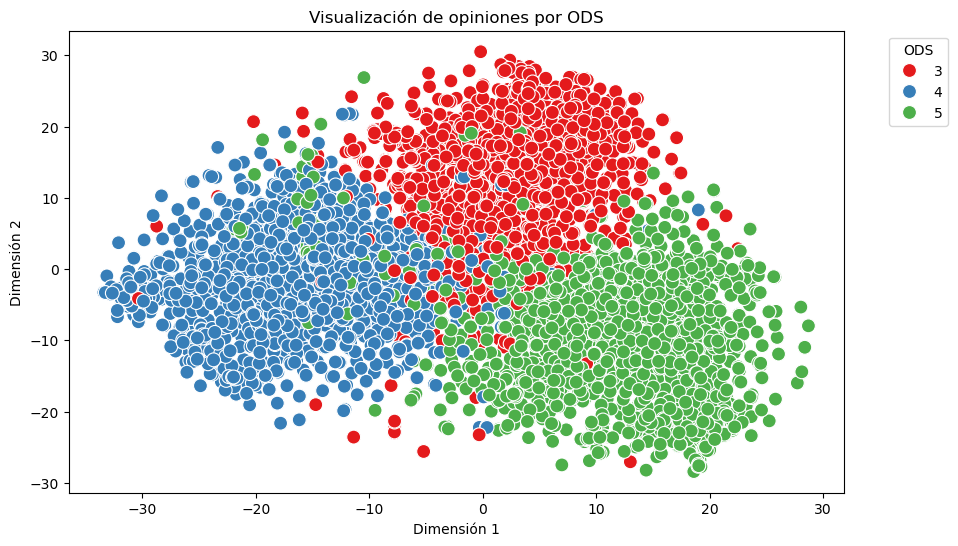

In [93]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['ODS'] = Y

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dim1', y='Dim2', hue='ODS', palette='Set1', data=tsne_df, s=100)

plt.title('Visualización de opiniones por ODS')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.legend(title='ODS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

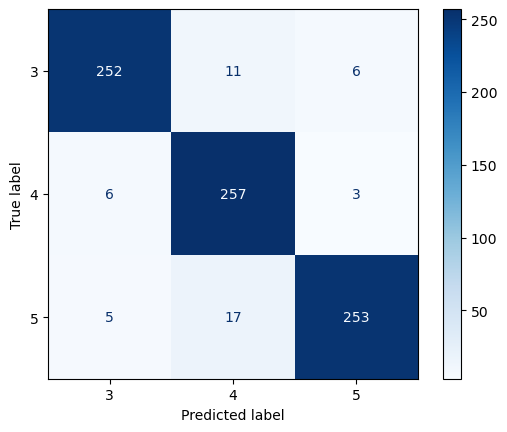

In [94]:
cm = confusion_matrix(Y_test, y_pred)
cmd_KNN = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
cmd_KNN.plot(cmap=plt.cm.Blues)
plt.show()

### 2.2) Random Forest

[Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [95]:
rf_data = raw_data.copy()
rf_data['tokens_normalizados'] = rf_data['tokens_normalizados'].apply(lambda x: ' '.join(map(str, x)))

X = rf_data['tokens_normalizados']
Y = rf_data['sdg']

count = CountVectorizer()
X = count.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [96]:
trees = 50

forest = RandomForestClassifier(n_estimators=trees)
forest = forest.fit(X_train, Y_train)
y_pred = forest.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           3       0.97      0.97      0.97       269
           4       0.96      0.97      0.96       266
           5       0.95      0.95      0.95       275

    accuracy                           0.96       810
   macro avg       0.96      0.96      0.96       810
weighted avg       0.96      0.96      0.96       810



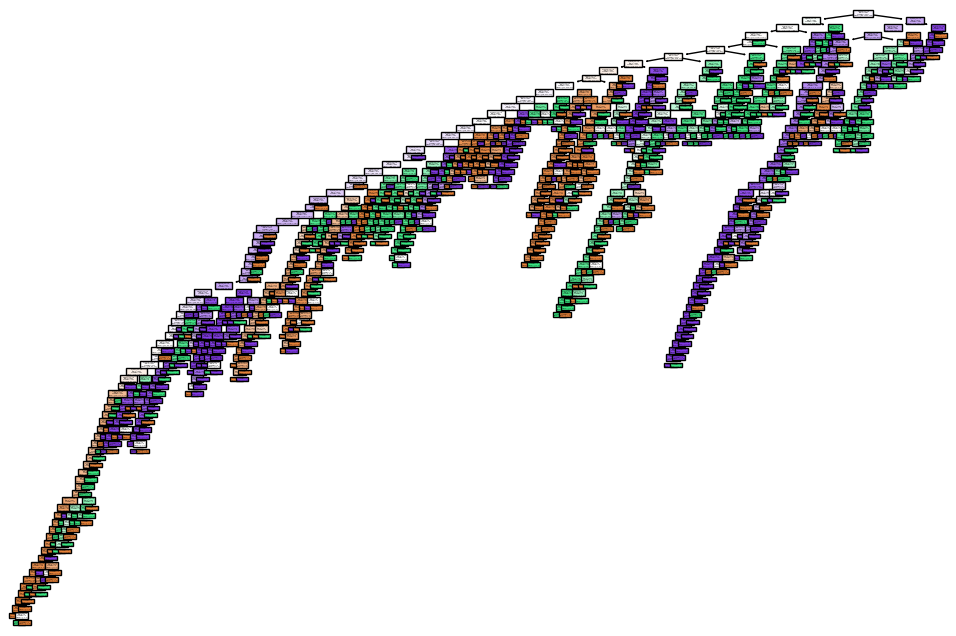

In [97]:
                   
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

individual_tree = forest.estimators_[0]
plt.figure(figsize=(12, 8))
plot_tree(individual_tree, filled=True)
plt.show()

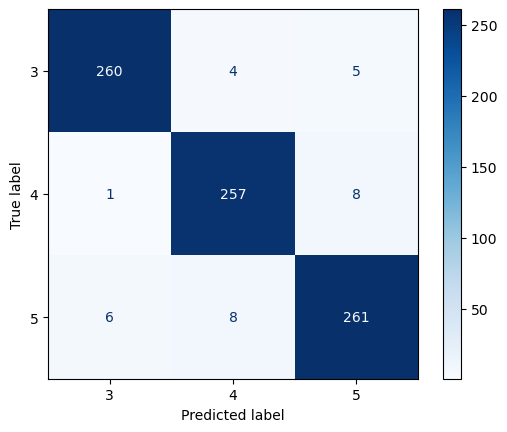

In [98]:
cm = confusion_matrix(Y_test, y_pred)
cmd_RF = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
cmd_RF.plot(cmap=plt.cm.Blues)
plt.show()

### 2.3) MLP Classifier 

[MLP Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [99]:
mlp_data = raw_data.copy()
mlp_data['tokens_normalizados'] = mlp_data['tokens_normalizados'].apply(lambda x: ' '.join(map(str, x)))

X = mlp_data['tokens_normalizados']
Y = mlp_data['sdg']

count = CountVectorizer()
X = count.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [100]:
MLP = MLPClassifier()
MLP = MLP.fit(X_train, Y_train)
y_pred = MLP.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           3       0.98      0.99      0.99       269
           4       0.98      0.97      0.98       266
           5       0.97      0.96      0.97       275

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



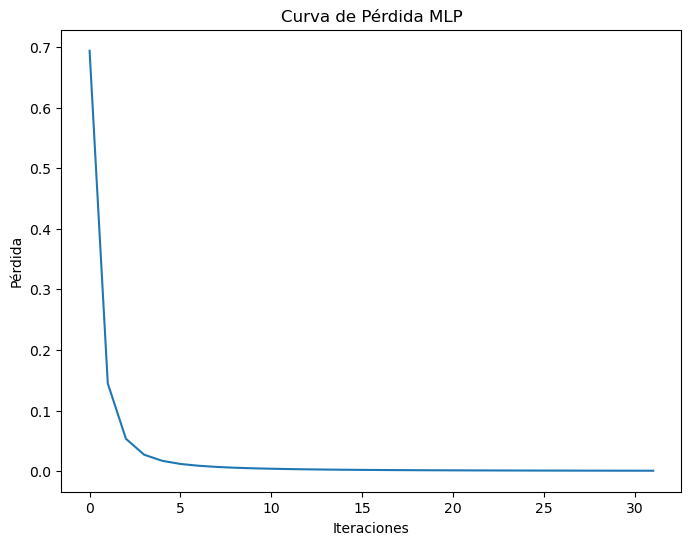

In [101]:
mlp_loss_curve = MLP.loss_curve_
plt.figure(figsize=(8,6))
plt.plot(mlp_loss_curve)
plt.title('Curva de Pérdida MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.show()

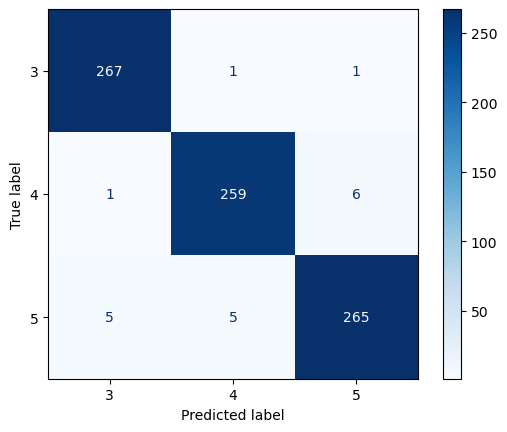

In [102]:
cm = confusion_matrix(Y_test, y_pred)
cmd_MLP = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
cmd_MLP.plot(cmap=plt.cm.Blues)
plt.show()

## 3) Análisis de Resultados

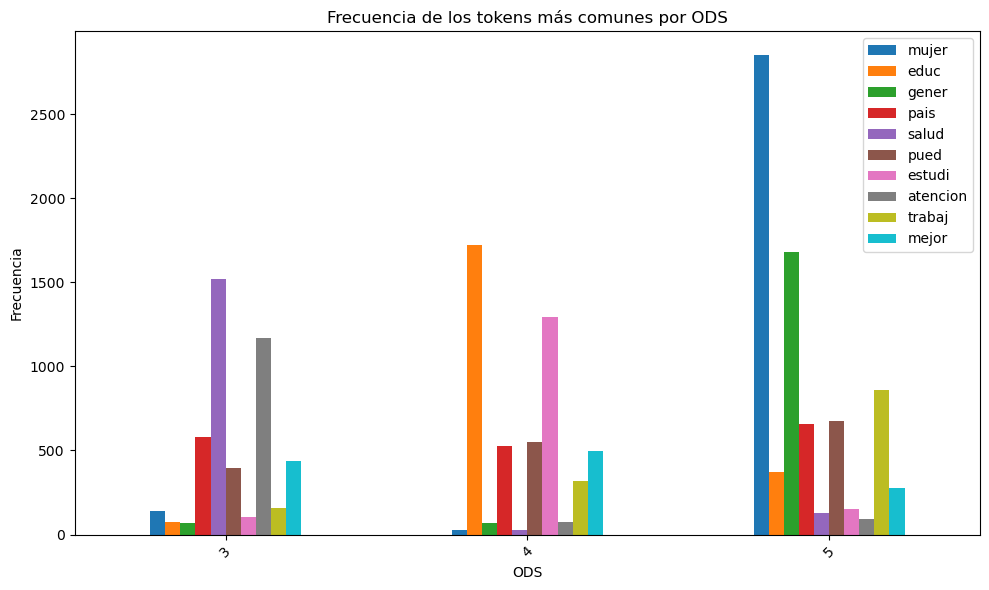

In [103]:
tokens_df = pd.DataFrame(X.toarray(), columns=count.get_feature_names_out())
tokens_df['ODS'] = Y

grouped_tokens = tokens_df.groupby('ODS').sum()
top_tokens = grouped_tokens.sum().sort_values(ascending=False).head(10).index

grouped_tokens[top_tokens].plot(kind='bar', figsize=(10,6))
plt.title('Frecuencia de los tokens más comunes por ODS')
plt.ylabel('Frecuencia')
plt.xlabel('ODS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4) Clasificación de los Datos de Prueba

In [104]:
#exportar excel
#prueba = raw_data
#prueba.to_excel("output.xlsx", index = False)